In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# pip install textract


In [14]:
### Resume Datatset

# Required libraries/ packages
import pandas as pd
import re
import textract
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report


In [15]:
# df=pd.read_csv(r"C:\Users\acer\Downloads\UpdatedResumeDataSet.csv\UpdatedResumeDataSet.csv")
df=pd.read_csv("/content/drive/MyDrive/nus-sds-train-data-set/UpdatedResumeDataSet.csv")

# dataset source https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset

df.info() # nice, all non null
df['Category'].value_counts(normalize=True) # nt exactly suuuuper even but ok ah
# can prob replicate those ard 40> get each category to around 80?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


Java Developer               0.087318
Testing                      0.072765
DevOps Engineer              0.057173
Python Developer             0.049896
Web Designing                0.046778
HR                           0.045738
Hadoop                       0.043659
Blockchain                   0.041580
ETL Developer                0.041580
Operations Manager           0.041580
Data Science                 0.041580
Sales                        0.041580
Mechanical Engineer          0.041580
Arts                         0.037422
Database                     0.034304
Electrical Engineering       0.031185
Health and fitness           0.031185
PMO                          0.031185
Business Analyst             0.029106
DotNet Developer             0.029106
Automation Testing           0.027027
Network Security Engineer    0.025988
SAP Developer                0.024948
Civil Engineer               0.024948
Advocate                     0.020790
Name: Category, dtype: float64

In [16]:
'''
up_df=pd.DataFrame(columns=['Category','Resume'])
for e in df['Category'].unique():
    cat=df[df['Category']==e]['Category']
    val_counts=cat.value_counts().values[0]
    up=80-val_counts
    if up<0:
        res=0
    elif up>val_counts:
        res=val_counts
    else:
        res=up
    for i,r in (df.iloc[(cat.sample(res).index)]).iterrows():
        up_df.loc[len(up_df)]=r
sample_df=pd.concat([df,up_df],axis=0)'''
# initial intentions were to upsamle the dataset via replacement; however given the number of
# resamples required - would likely affect ability of model to accurately predict the data
# (given that there'd be a high probability of "predicting" the data it had already been trained on)

"\nup_df=pd.DataFrame(columns=['Category','Resume'])\nfor e in df['Category'].unique():\n    cat=df[df['Category']==e]['Category']\n    val_counts=cat.value_counts().values[0]\n    up=80-val_counts\n    if up<0:\n        res=0\n    elif up>val_counts:\n        res=val_counts\n    else:\n        res=up\n    for i,r in (df.iloc[(cat.sample(res).index)]).iterrows():\n        up_df.loc[len(up_df)]=r\nsample_df=pd.concat([df,up_df],axis=0)"

In [17]:
sample_df=df
sample_df['Category'].value_counts(normalize=True) # much more even distribution

Java Developer               0.087318
Testing                      0.072765
DevOps Engineer              0.057173
Python Developer             0.049896
Web Designing                0.046778
HR                           0.045738
Hadoop                       0.043659
Blockchain                   0.041580
ETL Developer                0.041580
Operations Manager           0.041580
Data Science                 0.041580
Sales                        0.041580
Mechanical Engineer          0.041580
Arts                         0.037422
Database                     0.034304
Electrical Engineering       0.031185
Health and fitness           0.031185
PMO                          0.031185
Business Analyst             0.029106
DotNet Developer             0.029106
Automation Testing           0.027027
Network Security Engineer    0.025988
SAP Developer                0.024948
Civil Engineer               0.024948
Advocate                     0.020790
Name: Category, dtype: float64

In [18]:
## Time to clean the dataset

# Analyse roles first > check if any overlap is present
sorted(sample_df['Category'].unique()) # unique, all single cat,
# no real overlap due to diff cases (Data Science vs data science)
# will leave category as it is

['Advocate',
 'Arts',
 'Automation Testing',
 'Blockchain',
 'Business Analyst',
 'Civil Engineer',
 'Data Science',
 'Database',
 'DevOps Engineer',
 'DotNet Developer',
 'ETL Developer',
 'Electrical Engineering',
 'HR',
 'Hadoop',
 'Health and fitness',
 'Java Developer',
 'Mechanical Engineer',
 'Network Security Engineer',
 'Operations Manager',
 'PMO',
 'Python Developer',
 'SAP Developer',
 'Sales',
 'Testing',
 'Web Designing']

In [19]:
sample_df['Resume'].head() # for some resumes, have odd symbols (â¢/â )
# could be due to diff encoding format; likely punctuation formats nt accepted
# also contain newline char that are unnecessary: will focus on alphabets and numbers

0    Skills * Programming Languages: Python (pandas...
1    Education Details \r\nMay 2013 to May 2017 B.E...
2    Areas of Interest Deep Learning, Control Syste...
3    Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4    Education Details \r\n MCA   YMCAUST,  Faridab...
Name: Resume, dtype: object

In [20]:
sample_df['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

In [21]:
sample_df['Resume']=sample_df['Resume'].apply(lambda x:str(' '.join(re.findall('[a-zA-Z0-9]+',x)).lower()))
# get only letters and numbers; conver all to lowercase for standardization purposes
# will mean focus won't be on tokenizing sentences; rather more so on keyword id <Tf-IDF?>
# now will be to ID smth like common phrases/ words?
# but first > training and testing data

In [22]:
X_train,X_test,y_train,y_test = train_test_split(sample_df['Resume'],\
sample_df['Category'],stratify=sample_df['Category'],random_state=27)

<Axes: >

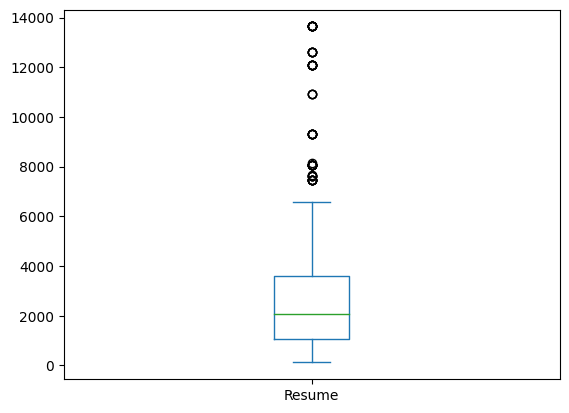

In [23]:
## NLTK > could look at TFIDF/ n-gram bag of words > key is to get smth dense;
# don't want a sparse vector for a model to be trained on
# have to consider fluff stop words as well > id only the key words;
# but for word2vec approach - overall meaning of sentences wld be useful

# speaking of

X_train.str.len().plot(kind='box') # q a large range, w decent number of outliers
# will monitor effect on dataset but for now will proceed with modelling

In [24]:
# as for creating vectors
vector=TfidfVectorizer(stop_words='english')
X_mod_train=vector.fit_transform(X_train)
X_mod_train.toarray().shape

(721, 7276)

In [25]:
encoder = preprocessing.LabelEncoder()
y_mod_train=encoder.fit_transform(y_train)

In [26]:
clf = GradientBoostingClassifier(max_depth=1)
clf.fit(X_mod_train,y_mod_train)

GradientBoostingClassifier(max_depth=1)

In [27]:
X_mod_test=vector.transform(X_test)
y_mod_test=encoder.transform(y_test)

y_pred = clf.predict(X_mod_test)

In [28]:
print(classification_report(y_mod_test,y_pred,target_names=encoder.classes_)) # Impressive!

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         5
                     Arts       1.00      1.00      1.00         9
       Automation Testing       1.00      1.00      1.00         6
               Blockchain       1.00      1.00      1.00        10
         Business Analyst       1.00      1.00      1.00         7
           Civil Engineer       1.00      1.00      1.00         6
             Data Science       1.00      1.00      1.00        10
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      1.00      1.00        14
         DotNet Developer       1.00      1.00      1.00         7
            ETL Developer       1.00      1.00      1.00        10
   Electrical Engineering       1.00      1.00      1.00         7
                       HR       1.00      1.00      1.00        11
                   Hadoop       1.00      1.00      1.00     

In [29]:
raw_resume_1 = '''Hello there, my name is <name>. I am interested in this position, having had
significant experience in Python programming and SQL. I am also extremely familiar with
Microsoft Excel and PowerBI.
I am currently an undergraduate of the National University of Singapore in Data Science and Analysis.

I have
had prior experience in programming for 3 years and am familiar with most
machine-learning models, ranging from
Logistic Regression Algorithms to Gradient Boosting Algorithms to Kmeans and Apriori algorithms.
I have also had past experience in working on a company's project related to Data Analysis; focusing on
statistcal data analysis of companies to determine capable ones to invest in.
It is with such experience that I believe I will be able to play a great role in the position offered'''

raw_resume_2 = '''Hello there, my name is <name>. I am interested in this position, having had
significant experience in Python programming for nearly 3 years.

I am also extremely
familiar with other programming languages
such as JavaScript and SQL, and am currently an undergraduate of the National
University of Singapore in Data Science and Analytics.
I have coded my own personal projects in Python, ranging from Telegram Bots for ticketing
systems to Image recognition software for outlining objects. While not having had any prior
experience in a company, I believe that with my fervent desire in Python and the skills I have
acquired over the years, I will be able to play a deep role in the position offered.'''

def resume_predictor(raw_resume):
    resume_processed = ' '.join(re.findall('[a-zA-Z0-9]+',raw_resume)).lower()
    vec=vector.transform([resume_processed])
    return encoder.classes_[clf.predict(vec)[0]]

print('raw_resume_1 role prediction:',resume_predictor(raw_resume_1))
print('raw_resume_2 role prediction:',resume_predictor(raw_resume_2))
# NICE > especially considering relative similarity of resumes in terms of syntax structure and all

raw_resume_1 role prediction: Data Science
raw_resume_2 role prediction: Python Developer


In [32]:
import re
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# 1. Create a custom transformer
class ResumeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Process each resume in X
        transformed_data = []
        for resume in X:
            processed_resume = ' '.join(re.findall('[a-zA-Z0-9]+', resume)).lower()
            transformed_data.append(processed_resume)
        return transformed_data

# Assuming you've defined 'vector', 'clf', and 'encoder' earlier in your code

# 2. Construct the pipeline
pipeline = Pipeline([
    ('resume_transformer', ResumeTransformer()),
    ('vectorizer', vector),
    ('classifier', clf)
])

# 3. Save the pipeline to a pickle file
with open("resume_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)